In [1]:
import ezkl
import torch
from torch import nn
import json
import os
import time
import scipy
import numpy as np
import matplotlib.pyplot as plt
import statistics
import math

In [2]:
%run -i ../../bench.py

In [3]:
data_50_path = os.path.join('data_50.json')
data_100_path = os.path.join('data_100.json')
data_300_path = os.path.join('data_300.json')
data_600_path = os.path.join('data_600.json')
data_1000_path = os.path.join('data_1000.json')

In [33]:
def gen_param_func(data_tensor_array):
    # for 1 column, just have 1 element in tensor array
    data = data_tensor_array[0].reshape(-1).numpy()
    return [torch.tensor(np.median(data)),torch.tensor(np.sort(data)[int(len(data)/2)-1]), torch.tensor(np.sort(data)[int(len(data)/2)]) ]
    return [torch.tensor(np.median(data)),torch.tensor(np.sort(data, axis = 1)[0][int(len(data[0])/2)-1][0]), torch.tensor(np.sort(data, axis = 1)[0][int(len(data[0])/2)][0]) ]

def model_func(param):
    # print("median: ", param[0])
    # print("lower: ", param[1])
    # print("upper: ", param[2])
    class verifier_model(nn.Module):
        def __init__(self):
            super(verifier_model, self).__init__()
            self.w = nn.Parameter(data = param[0], requires_grad = False)
            self.lower = nn.Parameter(data = param[1], requires_grad = False)
            self.upper = nn.Parameter(data = param[2], requires_grad = False)

        def forward(self,X):
            # since within 1%, we regard as same value
            count_less = torch.sum((X < 0.99*self.w).double())
            count_equal = torch.sum((torch.abs(X-self.w)<=torch.abs(0.01*self.w)).double())
            len = X.size()[1]
            half_len = torch.floor(torch.div(len, 2))
        
            # not support modulo yet
            less_cons = count_less<half_len+2*(len/2 - torch.floor(len/2))
            more_cons = count_less+count_equal>half_len

            # For count_equal == 0
            lower_exist = torch.sum((torch.abs(X-self.lower)<=torch.abs(0.01*self.lower)).double())>0
            lower_cons = torch.sum((X>1.01*self.lower).double())==half_len
            upper_exist = torch.sum((torch.abs(X-self.upper)<=torch.abs(0.01*self.upper)).double())>0
            upper_cons = torch.sum((X<0.99*self.upper).double())==half_len
            bound = count_less==half_len
            # 0.02 since 2*0.01
            bound_avg = (torch.abs(self.lower+self.upper-2*self.w)<=torch.abs(0.02*self.w))

            median_in_cons = torch.logical_and(less_cons, more_cons)
            median_out_cons = torch.logical_and(torch.logical_and(bound, bound_avg), torch.logical_and(torch.logical_and(lower_cons, upper_cons), torch.logical_and(lower_exist, upper_exist)))
        
            return(torch.where(count_equal==0, median_out_cons, median_in_cons), self.w)

    return verifier_model


sm_time =[0,0,0,0,0]
med_time = [0,0,0,0,0]
lar_time = [0,0,0,0,0]

Summary of Proving Time (1% accuracy)

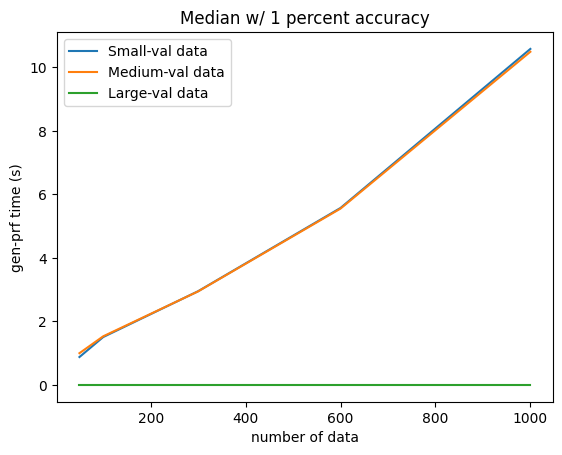

In [50]:
# Hence calibrate scale accordingly to compres the circuit size as long as the answer still within 1 percent
import matplotlib.pyplot as plt
data_number = [50, 100, 300, 600, 1000]
# sm_time = [0.9221072196960449, 1.6463661193847656, 2.9852941036224365, 5.603499889373779, 10.428229093551636]
plt.title("Median w/ 1 percent accuracy")
plt.xlabel("number of data")
plt.ylabel("gen-prf time (s)")
plt.plot(data_number, sm_time, label = 'Small-val data')

# med_time = [0.95278000831604, 1.6076688766479492, 2.848428726196289, 5.747658014297485, 10.373636245727539]
plt.plot(data_number, med_time, label = 'Medium-val data')

# lar_time = [4.8463828563690186, 5.027441024780273, 5.324703931808472, 5.739445924758911, 10.433889865875244]
plt.plot(data_number, lar_time, label = 'Large-val data')


plt.legend()


=============================================================================================================

Small-Valued Data: value 0-1, 3 decimals on 50, 100, 300, 600, 1000 data

In [34]:
sm_time[0] = bench_one(data_50_path,['small'], model_func,gen_param_func, "50 small values","default", 12,"resources")

=====================================  50 small values  =====================================


spawning module 0
spawning module 2


og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 9, 'param_scale': 9, 'scale_rebase_multiplier': 10, 'lookup_range': [-516, 1024], 'logrows': 12, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 3936, 'total_assignments': 2046, 'total_const_size': 316, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 9], 'model_input_scales': [9], 'module_sizes': {'kzg': [], 'poseidon': [3936, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 9, 'param_scale': 9, 'scale_rebase_multiplier': 10, 'lookup_range': [-516, 1024], 'logrows': 12, 'num_inner_cols': 2, 'variables': [['batch_size', 

spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  0.87841796875
Theory result:  tensor(0.5160, dtype=torch.float64)
Our result:  [0.515625]


In [35]:
sm_time[1] = bench_one(data_100_path,['small'], model_func,gen_param_func, "100 small values","default", 13,"resources")

=====================================  100 small values  =====================================


spawning module 0
spawning module 2


og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 9, 'param_scale': 9, 'scale_rebase_multiplier': 10, 'lookup_range': [-1024, 2048], 'logrows': 13, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 6560, 'total_assignments': 4046, 'total_const_size': 616, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 9], 'model_input_scales': [9], 'module_sizes': {'kzg': [], 'poseidon': [6560, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 9, 'param_scale': 9, 'scale_rebase_multiplier': 10, 'lookup_range': [-1024, 2048], 'logrows': 13, 'num_inner_cols': 2, 'variables': [['batch_size'

spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  1.5067381858825684
Theory result:  tensor(0.5135, dtype=torch.float64)
Our result:  [0.513671875]


In [36]:
sm_time[2] = bench_one(data_300_path,['small'], model_func,gen_param_func, "300 small values","default", 14,"resources")

=====================================  300 small values  =====================================


spawning module 0
spawning module 2


og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 9, 'param_scale': 9, 'scale_rebase_multiplier': 10, 'lookup_range': [-1024, 3072], 'logrows': 14, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 14432, 'total_assignments': 12046, 'total_const_size': 1816, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 9], 'model_input_scales': [9], 'module_sizes': {'kzg': [], 'poseidon': [14432, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 9, 'param_scale': 9, 'scale_rebase_multiplier': 10, 'lookup_range': [-1024, 3072], 'logrows': 14, 'num_inner_cols': 2, 'variables': [['batch_s

spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  2.9502851963043213
Theory result:  tensor(0.5050, dtype=torch.float64)
Our result:  [0.505859375]


In [37]:
sm_time[3] = bench_one(data_600_path,['small'], model_func,gen_param_func, "600 small values","default", 15,"resources")

=====================================  600 small values  =====================================


spawning module 0
spawning module 2


og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 9, 'param_scale': 9, 'scale_rebase_multiplier': 10, 'lookup_range': [-8192, 12288], 'logrows': 15, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 26240, 'total_assignments': 24046, 'total_const_size': 3616, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 9], 'model_input_scales': [9], 'module_sizes': {'kzg': [], 'poseidon': [26240, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 9, 'param_scale': 9, 'scale_rebase_multiplier': 10, 'lookup_range': [-8192, 12288], 'logrows': 15, 'num_inner_cols': 2, 'variables': [['batch

spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  5.571526765823364
Theory result:  tensor(0.4880, dtype=torch.float64)
Our result:  [0.48828125]


In [38]:
sm_time[4] = bench_one(data_1000_path,['small'], model_func,gen_param_func, "1000 small values","default", 16,"resources")

=====================================  1000 small values  =====================================


spawning module 0
spawning module 2


og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 9, 'param_scale': 9, 'scale_rebase_multiplier': 10, 'lookup_range': [-9216, 20480], 'logrows': 16, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 45920, 'total_assignments': 40046, 'total_const_size': 6016, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 9], 'model_input_scales': [9], 'module_sizes': {'kzg': [], 'poseidon': [45920, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 9, 'param_scale': 9, 'scale_rebase_multiplier': 10, 'lookup_range': [-9216, 20480], 'logrows': 16, 'num_inner_cols': 2, 'variables': [['batch

spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  10.57955813407898
Theory result:  tensor(0.4825, dtype=torch.float64)
Our result:  [0.482421875]


=============================================================================================================

Medium data: value 1-100, 1 decimal on 50, 100, 300, 600, 1000 data

In [44]:
# can use "default" which will set to scale 8, but overkill, we just want 1% accuracy
med_time[0] = bench_one(data_50_path,['medium'], model_func,gen_param_func, "50 medium values",[3],12, "resources")

spawning module 0
spawning module 2


=====================================  50 medium values  =====================================
og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 3, 'param_scale': 3, 'scale_rebase_multiplier': 10, 'lookup_range': [-976, 986], 'logrows': 12, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 3936, 'total_assignments': 2046, 'total_const_size': 316, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 3], 'model_input_scales': [3], 'module_sizes': {'kzg': [], 'poseidon': [3936, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 3, 'param_scale': 3, 'scale_rebase_multiplier': 10, '

spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  0.9988489151000977
Theory result:  tensor(39.3000, dtype=torch.float64)
Our result:  [39.25]


In [46]:
med_time[1] = bench_one(data_100_path,['medium'], model_func,gen_param_func, "100 medium values",[3],13, "resources")

spawning module 0
spawning module 2


=====================================  100 medium values  =====================================
og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 3, 'param_scale': 3, 'scale_rebase_multiplier': 10, 'lookup_range': [-886, 882], 'logrows': 13, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 6560, 'total_assignments': 4046, 'total_const_size': 616, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 3], 'model_input_scales': [3], 'module_sizes': {'kzg': [], 'poseidon': [6560, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 3, 'param_scale': 3, 'scale_rebase_multiplier': 10, 

spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  1.5304572582244873
Theory result:  tensor(44.9000, dtype=torch.float64)
Our result:  [44.875]


In [47]:
med_time[2] = bench_one(data_300_path,['medium'], model_func,gen_param_func, "300 medium values",[3],14, "resources")

=====================================  300 medium values  =====================================


spawning module 0
spawning module 2


og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 3, 'param_scale': 3, 'scale_rebase_multiplier': 10, 'lookup_range': [-836, 830], 'logrows': 14, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 14432, 'total_assignments': 12046, 'total_const_size': 1816, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 3], 'model_input_scales': [3], 'module_sizes': {'kzg': [], 'poseidon': [14432, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 3, 'param_scale': 3, 'scale_rebase_multiplier': 10, 'lookup_range': [-836, 830], 'logrows': 14, 'num_inner_cols': 2, 'variables': [['batch_size'

spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  2.944689989089966
Theory result:  tensor(48.0500, dtype=torch.float64)
Our result:  [48.0]


In [48]:
med_time[3] = bench_one(data_600_path,['medium'], model_func,gen_param_func, "600 medium values",[3],15, "resources")

=====================================  600 medium values  =====================================


spawning module 0
spawning module 2


og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 3, 'param_scale': 3, 'scale_rebase_multiplier': 10, 'lookup_range': [-828, 826], 'logrows': 15, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 26240, 'total_assignments': 24046, 'total_const_size': 3616, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 3], 'model_input_scales': [3], 'module_sizes': {'kzg': [], 'poseidon': [26240, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 3, 'param_scale': 3, 'scale_rebase_multiplier': 10, 'lookup_range': [-828, 826], 'logrows': 15, 'num_inner_cols': 2, 'variables': [['batch_size'

spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  5.551953077316284
Theory result:  tensor(48.5500, dtype=torch.float64)
Our result:  [48.5]


In [49]:
med_time[4] = bench_one(data_1000_path,['medium'], model_func,gen_param_func, "1000 medium values",[3],16, "resources")

=====================================  1000 medium values  =====================================


spawning module 0
spawning module 2


og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 3, 'param_scale': 3, 'scale_rebase_multiplier': 10, 'lookup_range': [-802, 796], 'logrows': 16, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 45920, 'total_assignments': 40046, 'total_const_size': 6016, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 3], 'model_input_scales': [3], 'module_sizes': {'kzg': [], 'poseidon': [45920, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 3, 'param_scale': 3, 'scale_rebase_multiplier': 10, 'lookup_range': [-802, 796], 'logrows': 16, 'num_inner_cols': 2, 'variables': [['batch_size'

spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  10.490262746810913
Theory result:  tensor(50.4000, dtype=torch.float64)
Our result:  [50.375]


=============================================================================================================

Large-valued data: value 100-10000, 0 decimal on 50, 100, 300, 600, 1000 data

In [19]:
lar_time = [0,0,0,0,0]

In [20]:
lar_time[0] = bench_one(data_50_path,['large'], model_func,gen_param_func, "50 large values",[0],15, "resources")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:2174: FutureWarning: 'torch.onnx.symbolic_opset9._cast_Bool' is deprecated in version 2.0 and will be removed in the future. Please Avoid using this function and create a Cast node instead.
  return fn(g, to_cast_func(g, input, False), to_cast_func(g, other, False))
spawning module 0
spawning module 2


=====================================  50 large values  =====================================
og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 'lookup_range': [-9448, 9438], 'logrows': 15, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 3936, 'total_assignments': 2037, 'total_const_size': 308, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 0], 'model_input_scales': [0], 'module_sizes': {'kzg': [], 'poseidon': [3936, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 

spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  4.935945987701416
Theory result:  tensor(5344.5000, dtype=torch.float64)
Our result:  [5345.0]


In [21]:
lar_time[0] = bench_one(data_50_path,['large'], model_func,gen_param_func, "50 large values",[0],14, "resources")

Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
spawning module 0
spawning module 2


=====================================  50 large values  =====================================
og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 'lookup_range': [-9448, 9438], 'logrows': 15, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 3936, 'total_assignments': 2037, 'total_const_size': 308, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 0], 'model_input_scales': [0], 'module_sizes': {'kzg': [], 'poseidon': [3936, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 

Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
spawning module 0
spawning module 2
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
spawning module 0
spawning module 2
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.


gen prf time:  3.8993990421295166
Theory result:  tensor(5344.5000, dtype=torch.float64)
Our result:  [5345.0]


In [22]:
lar_time[0] = bench_one(data_50_path,['large'], model_func,gen_param_func, "50 large values",[0],13, "resources")

Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
spawning module 0
spawning module 2
Using 3 columns for non-linearity table.


=====================================  50 large values  =====================================
og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 'lookup_range': [-9448, 9438], 'logrows': 15, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 3936, 'total_assignments': 2037, 'total_const_size': 308, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 0], 'model_input_scales': [0], 'module_sizes': {'kzg': [], 'poseidon': [3936, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 

Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
spawning module 0
spawning module 2
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
spawning module 0
spawning module 2
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.


gen prf time:  2.8503921031951904
Theory result:  tensor(5344.5000, dtype=torch.float64)
Our result:  [5345.0]


In [23]:
lar_time[0] = bench_one(data_50_path,['large'], model_func,gen_param_func, "50 large values",[0],12, "resources")

Using 5 columns for non-linearity table.
Using 5 columns for non-linearity table.
Using 5 columns for non-linearity table.
spawning module 0
spawning module 2
Using 5 columns for non-linearity table.


=====================================  50 large values  =====================================
og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 'lookup_range': [-9448, 9438], 'logrows': 15, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 3936, 'total_assignments': 2037, 'total_const_size': 308, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 0], 'model_input_scales': [0], 'module_sizes': {'kzg': [], 'poseidon': [3936, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 

Using 5 columns for non-linearity table.
Using 5 columns for non-linearity table.
spawning module 0
spawning module 2
Using 5 columns for non-linearity table.
Using 5 columns for non-linearity table.
Using 5 columns for non-linearity table.
Using 5 columns for non-linearity table.
Using 5 columns for non-linearity table.
Using 5 columns for non-linearity table.
spawning module 0
spawning module 2
Using 5 columns for non-linearity table.
Using 5 columns for non-linearity table.
Using 5 columns for non-linearity table.


gen prf time:  2.5629518032073975
Theory result:  tensor(5344.5000, dtype=torch.float64)
Our result:  [5345.0]


In [24]:
lar_time[1] = bench_one(data_100_path,['large'], model_func,gen_param_func, "100 large values",[0],15, "resources")

spawning module 0
spawning module 2


=====================================  100 large values  =====================================
og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 'lookup_range': [-10394, 10324], 'logrows': 15, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 6560, 'total_assignments': 4037, 'total_const_size': 608, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 0], 'model_input_scales': [0], 'module_sizes': {'kzg': [], 'poseidon': [6560, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 1

spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  4.735892057418823
Theory result:  tensor(4825.5000, dtype=torch.float64)
Our result:  [4826.0]


In [25]:
lar_time[1] = bench_one(data_100_path,['large'], model_func,gen_param_func, "100 large values",[0],14, "resources")

Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.


=====================================  100 large values  =====================================
og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 'lookup_range': [-10394, 10324], 'logrows': 15, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 6560, 'total_assignments': 4037, 'total_const_size': 608, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 0], 'model_input_scales': [0], 'module_sizes': {'kzg': [], 'poseidon': [6560, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 1

spawning module 0
spawning module 2
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
spawning module 0
spawning module 2
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
spawning module 0
spawning module 2
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.


gen prf time:  3.9381980895996094
Theory result:  tensor(4825.5000, dtype=torch.float64)
Our result:  [4826.0]


In [26]:
lar_time[1] = bench_one(data_100_path,['large'], model_func,gen_param_func, "100 large values",[0],13, "resources")

Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
spawning module 0
spawning module 2


=====================================  100 large values  =====================================
og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 'lookup_range': [-10394, 10324], 'logrows': 15, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 6560, 'total_assignments': 4037, 'total_const_size': 608, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 0], 'model_input_scales': [0], 'module_sizes': {'kzg': [], 'poseidon': [6560, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 1

Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
spawning module 0
spawning module 2
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
spawning module 0
spawning module 2
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.


gen prf time:  3.0223019123077393
Theory result:  tensor(4825.5000, dtype=torch.float64)
Our result:  [4826.0]


In [27]:
lar_time[2] = bench_one(data_300_path,['large'], model_func,gen_param_func, "300 large values",[0],15, "resources")

=====================================  300 large values  =====================================


spawning module 0
spawning module 2


og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 'lookup_range': [-10236, 10092], 'logrows': 15, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 14432, 'total_assignments': 12037, 'total_const_size': 1808, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 0], 'model_input_scales': [0], 'module_sizes': {'kzg': [], 'poseidon': [14432, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 'lookup_range': [-10236, 10092], 'logrows': 15, 'num_inner_cols': 2, 'variables': [['bat

spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  5.122875213623047
Theory result:  tensor(5184., dtype=torch.float64)
Our result:  [5184.0]


In [28]:
lar_time[2] = bench_one(data_300_path,['large'], model_func,gen_param_func, "300 large values",[0],14, "resources")

=====================================  300 large values  =====================================


Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
spawning module 0
spawning module 2


og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 'lookup_range': [-10236, 10092], 'logrows': 15, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 14432, 'total_assignments': 12037, 'total_const_size': 1808, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 0], 'model_input_scales': [0], 'module_sizes': {'kzg': [], 'poseidon': [14432, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 'lookup_range': [-10236, 10092], 'logrows': 14, 'num_inner_cols': 2, 'variables': [['bat

Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
spawning module 0
spawning module 2
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
spawning module 0
spawning module 2
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.
Using 2 columns for non-linearity table.


gen prf time:  4.169323921203613
Theory result:  tensor(5184., dtype=torch.float64)
Our result:  [5184.0]


In [30]:
lar_time[3] = bench_one(data_600_path,['large'], model_func,gen_param_func, "600 large values",[0],15, "resources")

=====================================  600 large values  =====================================


spawning module 0
spawning module 2


og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 'lookup_range': [-10092, 10014], 'logrows': 15, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 26240, 'total_assignments': 24037, 'total_const_size': 3608, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 0], 'model_input_scales': [0], 'module_sizes': {'kzg': [], 'poseidon': [26240, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 'lookup_range': [-10092, 10014], 'logrows': 15, 'num_inner_cols': 2, 'variables': [['bat

spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  5.448761940002441
Theory result:  tensor(4990., dtype=torch.float64)
Our result:  [4990.0]


In [32]:
lar_time[4] = bench_one(data_1000_path,['large'], model_func,gen_param_func, "1000 large values",[0],16, "resources")

=====================================  1000 large values  =====================================


spawning module 0
spawning module 2


og setting:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 'lookup_range': [-10066, 9902], 'logrows': 16, 'num_inner_cols': 2, 'variables': [['batch_size', 1]], 'input_visibility': {'Hashed': {'hash_is_public': True, 'outlets': []}}, 'output_visibility': 'Public', 'param_visibility': 'Private'}, 'num_rows': 45920, 'total_assignments': 40037, 'total_const_size': 6008, 'model_instance_shapes': [[1], [1]], 'model_output_scales': [0, 0], 'model_input_scales': [0], 'module_sizes': {'kzg': [], 'poseidon': [45920, [1]], 'elgamal': [0, [0]]}, 'required_lookups': ['Abs', {'GreaterThan': {'a': 0.0}}, 'KroneckerDelta'], 'check_mode': 'UNSAFE', 'version': '7.0.0', 'num_blinding_factors': None}
logrow cal settings:  {'run_args': {'tolerance': {'val': 0.0, 'scale': 1.0}, 'input_scale': 0, 'param_scale': 0, 'scale_rebase_multiplier': 10, 'lookup_range': [-10066, 9902], 'logrows': 16, 'num_inner_cols': 2, 'variables': [['batch

spawning module 0
spawning module 2
spawning module 0
spawning module 2


gen prf time:  10.021524906158447
Theory result:  tensor(5094., dtype=torch.float64)
Our result:  [5094.0]
